Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

Load & Preprocess Data

In [ ]:
cb_model = pd.read_csv("/content/train_cleaned.csv")

In [ ]:
#define Features & Target
X = cb_model[['luxury_sales', 'fresh_sales', 'dry_sales','outlet_city']]
y = cb_model['cluster_category']

In [ ]:
# Split Data into Training & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Hyperparameter Tuning using Grid Search

In [ ]:
!pip install catboost

In [ ]:
#define CatBoost model with early stopping
catboost_classifier = CatBoostClassifier(
    verbose=0,
    random_seed=42,
    eval_metric='Accuracy',
    od_type='Iter',  #stops training if no improvement
    od_wait=20  #number of iterations with no improvement before stopping
)

#define optimized hyperparameter grid
param_dist = {
    'iterations': [50, 100, 150],  # Reduce iterations
    'learning_rate': [0.01, 0.03, 0.05],  # Lower learning rates
    'depth': [3, 4],  # Reduce tree depth to prevent overfitting
    'l2_leaf_reg': [10, 15],  # Higher regularization
    'grow_policy': ['Lossguide'],  # Prevents deep trees
    'random_strength': [5, 15]  # Adds randomness to splits
}

#perform Randomized Search (faster than Grid Search)
random_search = RandomizedSearchCV(
    catboost_classifier,
    param_distributions=param_dist,
    n_iter=10,  # Reduce iterations for speed
    cv=5,  # Increase cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

#fit the model
random_search.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

#best parameters
print("Best Parameters:", random_search.best_params_)

#train final model with best parameters
best_cb = random_search.best_estimator_

#evaluate
y_pred = best_cb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'random_strength': 15, 'learning_rate': 0.05, 'l2_leaf_reg': 15, 'iterations': 100, 'grow_policy': 'Lossguide', 'depth': 4}
Test Accuracy: 0.9823


Model Evaluation

In [ ]:
#predictions
y_pred = best_cb.predict(X_test)

#Training & Test Accuracy
train_accuracy = accuracy_score(y_train, best_cb.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

#Classification Report
print(classification_report(y_test, y_pred))

Training Accuracy: 0.9824
Test Accuracy: 0.9823
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     56688
           2       1.00      1.00      1.00     46515
           3       0.89      0.88      0.88     14667
           4       1.00      1.00      1.00     51728
           5       0.86      0.86      0.86     11857
           6       1.00      1.00      1.00     50762

    accuracy                           0.98    232217
   macro avg       0.95      0.95      0.95    232217
weighted avg       0.98      0.98      0.98    232217



Confusion Matrix

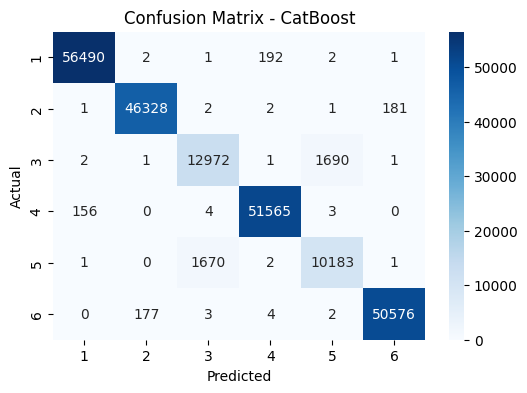

In [ ]:
#compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()

AUC-ROC Curve

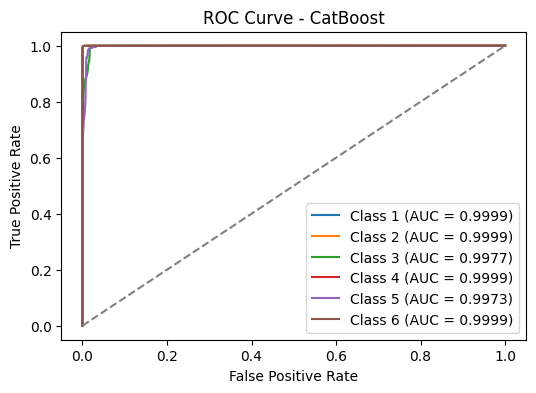

In [ ]:
#compute probabilities for ROC curve
y_probs = best_cb.predict_proba(X_test)

#'cluster_category' has more than two classes
# Choose 'ovr' (one-vs-rest) or 'ovo' (one-vs-one) for multi-class handling
auc_score = roc_auc_score(y_test, y_probs, multi_class='ovr')  # Or multi_class='ovo'

#plot ROC curve
plt.figure(figsize=(6,4))

#compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_probs.shape[1]  #the number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=best_cb.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot ROC curve for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {best_cb.classes_[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#split data into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#evaluate model on validation data
y_val_pred = best_cb.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

#compare with test data
y_test_pred = best_cb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.9824
Test Accuracy: 0.9822


Learning Curve

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2410, in _fit


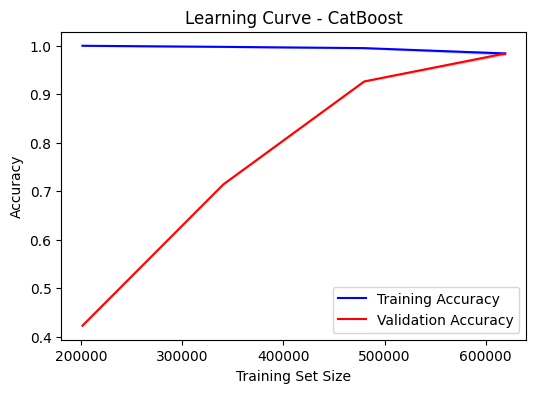

In [ ]:
#import the learning_curve function
from sklearn.model_selection import learning_curve

#compute learning curve
train_sizes, train_scores, val_scores = learning_curve(best_cb, X, y, cv=5, scoring='accuracy')

#compute mean and std deviation for training & validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

#plot Learning Curve
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label="Training Accuracy", color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color='red')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - CatBoost")
plt.legend()
plt.show()

Feature Importance

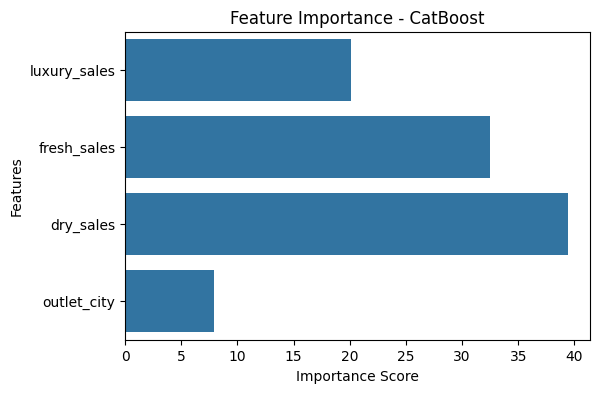

In [ ]:
#get feature importance
feature_importance = best_cb.get_feature_importance()
features = X.columns

#plot Feature Importance
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importance, y=features)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - CatBoost")
plt.show()